<a href="https://colab.research.google.com/github/maryamhashemi/Persian_VQA/blob/master/Demo_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a demo for persian visual question answering.

In [ ]:
! pip install hazm

     |████████████████████████████████| 317kB 6.8MB/s 
     |████████████████████████████████| 1.4MB 13.3MB/s 
     |████████████████████████████████| 235kB 34.1MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp36-none-any.whl size=1394469 sha256=4cbde4181d739d3072a52264e5519a6a932d86f560569a6f6fd9f475b8a335fa
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=155236 sha256=a7ab4c243a5d4fbeb3477562d4c267a3828e8c14a3fffbd13b13b382d3f5a4ca
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built nltk libwapiti
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
# import hazm
import json
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, BatchNormalization, Embedding, LSTM, Dropout, Input

In [ ]:
tf.keras.preprocessing.text.Tokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Load and Perprocess the image.

In [ ]:
def load_and_proccess_image(image_path):

    base_model = VGG16(include_top=False, weights='imagenet')
    model = Model(inputs=base_model.input,
                  outputs=base_model.get_layer('block5_pool').output)
    
    im = load_img(image_path, target_size=(448, 448, 3))
    x = img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    features = np.squeeze(features, axis=0).T

    return features

### Preprocess the question.

In [ ]:
VOCAB_SIZE = 0
with open('/content/drive/My Drive/Demo_VQA/tokenizer.pickle', 'rb') as file:
  tokenizer = pickle.load(file, encoding='utf-8')
  VOCAB_SIZE = len(tokenizer.word_index) + 1

In [ ]:
def preprocess_question(question):

    # normalize data
    normalizer = hazm.Normalizer()
    question = normalizer.normalize(question)
    question = question.replace('؟', ' ؟')

    # prepare train sequence
    question = tokenizer.texts_to_sequences([question])
    question = pad_sequences(question, maxlen=26, padding='pre')
    question = np.array(question)
    question = np.squeeze(question, axis=0)
    return question

### Build and Load pretrained model.

In [ ]:
class image_layer(Model):

    def __init__(self, **kwargs):
        super(image_layer, self).__init__(**kwargs)
        self.dense = Dense(1024, activation='tanh')

    def call(self, inputs):
        # (N, 512, 14, 14) -> (N, 512, 196)
        x = tf.reshape(inputs, [-1, inputs.shape[1],
                                inputs.shape[2]*inputs.shape[3]])

        # (N, 512, 196) -> (N, 196, 512)
        x = tf.transpose(x, perm=[0, 2, 1])

        # (N, 196, 512) -> (N, 196, 1024)
        x = self.dense(x)

        return x

In [ ]:
class question_layer_LSTM(Model):

    def __init__(self, num_words, embedding_dim, dropout_rate, seq_length, ** kwargs):
        super(question_layer_LSTM, self).__init__(**kwargs)

        self.embedding = Embedding(num_words,
                                   embedding_dim,
                                   input_length=seq_length,
                                   trainable=True)

        self.lstm1 = LSTM(units=1024, return_sequences=True,
                          recurrent_dropout=0.5)
        self.batch1 = BatchNormalization(center=False, scale=False)
        self.lstm2 = LSTM(units=1024, return_sequences=False,
                          recurrent_dropout=0.5)
        self.batch2 = BatchNormalization(center=False, scale=False)
        self.dense = Dense(1024, activation='tanh')

    def call(self, inputs):
        # (N, SEQ_LENGTH) -> (N, SEQ_LENGTH, embedding_dim)
        x = self.embedding(inputs)

        # (N, SEQ_LENGTH, embedding_dim) -> (N, SEQ_LENGTH, 512)
        x = self.lstm1(x)
        x = self.batch1(x)

        # (N, SEQ_LENGTH, 512) -> (N, 512)
        x = self.lstm2(x)
        x = self.batch2(x)

        # (N, 512) -> (N * 1024)
        x = self.dense(x)

        return x

In [ ]:
class attention_layer(Model):

    def __init__(self, attention_dim, **kwargs):
        super(attention_layer, self).__init__(**kwargs)
        self.wi = Dense(units=attention_dim, use_bias=False, activation=None)
        self.wq = Dense(units=attention_dim, activation=None)
        self.wpi = Dense(1, activation=None)
        self.dropout = Dropout(0.5)

    def call(self, inputs):
        vi, vq = inputs

        # (N, 196, 1024) -> (N, 196, attention_dim)
        hi = tf.tanh(self.wi(vi))

        # (N, 1024) -> (N, attention_dim)
        hq = tf.tanh(self.wq(vq))

        # (N, attention_dim) -> (N, 1, attention_dim)
        hq = tf.expand_dims(hq, axis=1)

        # (N, 196, attention_dim)
        ha = tf.tanh(hi + hq)

        ha = self.dropout(ha)

        # (N, 196, attention_dim) -> (N, 196,  1)
        pi = self.wpi(ha)

        # (N, 196,  1) -> (N, 196)
        pi = tf.squeeze(pi, axis=2)

        # (N, 196) -> (N, 196)
        pi = tf.keras.activations.softmax(pi)

        # (N, 196, 1), (N, 196, 1024) -> (N, 1024)
        vi_att = tf.reduce_sum(tf.expand_dims(pi, axis=2)*vi, axis=1)

        # (N, 1024)
        u = vi_att + vq

        return u

In [ ]:
def SAN_LSTM_2(num_classes, dropout_rate, num_words, embedding_dim, attention_dim):

    qs_input = Input(shape=(26,))
    img_input = Input(shape=(512, 14, 14))

    image_embed = image_layer()(img_input)
    ques_embed = question_layer_LSTM(num_words,
                                     embedding_dim,
                                     dropout_rate,
                                     26)(qs_input)

    att = attention_layer(attention_dim)([image_embed, ques_embed])
    att = attention_layer(attention_dim)([image_embed, att])

    att = Dropout(dropout_rate)(att)

    output = Dense(num_classes, activation='softmax')(att)

    model = Model(inputs=[qs_input, img_input], outputs=output)

    return model

In [ ]:
model = SAN_LSTM_2(1000,0.5,VOCAB_SIZE,300,512)
latest = tf.train.latest_checkpoint('/content/drive/My Drive/Demo_VQA/checkpoint/')
print(latest)
model.load_weights(latest)

/content/drive/My Drive/Demo_VQA/checkpoint/cp- 008.ckpt


In [ ]:
!zip -r /content/drive/My\ Drive/parssoftco_PVQA3/chk.zip /content/drive/My\ Drive/Demo_VQA/checkpoint/

  adding: content/drive/My Drive/Demo_VQA/checkpoint/ (stored 0%)
  adding: content/drive/My Drive/Demo_VQA/checkpoint/cp- 008.ckpt.index (deflated 73%)
  adding: content/drive/My Drive/Demo_VQA/checkpoint/cp- 008.ckpt.data-00001-of-00002 (deflated 8%)
  adding: content/drive/My Drive/Demo_VQA/checkpoint/checkpoint (deflated 40%)
  adding: content/drive/My Drive/Demo_VQA/checkpoint/cp- 008.ckpt.data-00000-of-00002 (deflated 6%)


### test

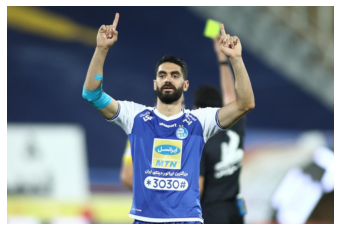

Question :پیراهن این فرد چه رنگی است؟
Top Predicted answers:  [('آبی', 52.07174), ('سبز', 21.75263), ('سفید', 13.174462), ('زرد', 3.577304), ('قرمز', 3.1382136)]


In [ ]:
question = 'پیراهن این فرد چه رنگی است؟'
image_path = '/content/01518480.jpg'


im_features = load_and_proccess_image(image_path)
ques_features = preprocess_question(question)

x_im = [im_features]
x_ques = [ques_features]

x_im = np.array(x_im)
x_ques = np.array(x_ques)

y_pred = model.predict([x_ques, x_im])

class_indices = tf.math.top_k(y_pred,k=5).indices.numpy()
percentages = tf.math.top_k(y_pred,k=5).values.numpy()[0] * 100

with open('/content/drive/My Drive/Demo_VQA/label2vocab.json', 'r') as file:
    ans_vocab =  json.load(file)

predictions = []
for idx,i in enumerate(class_indices[0]):
    predictions.append((ans_vocab[str(i)],percentages[idx]))



img=mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
print("Question :" + question)
print("Top Predicted answers: ",predictions)

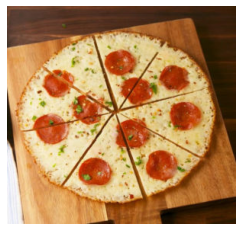

Question :چند قطعه پیتزا در تصویر وجود دارد؟
Top Predicted answers:  [('2', 38.61729), ('8', 15.428813), ('6', 10.407589), ('1', 9.958286), ('3', 7.563966)]


In [ ]:
question = 'لباس کودک چه رنگی است؟'
image_path = '/content/drive/My Drive/Demo_VQA/COCO_test2015_000000007594.jpg'

question = 'چند قطعه پیتزا در تصویر وجود دارد؟'
image_path = '/content/4-8-300x286.jpg'


im_features = load_and_proccess_image(image_path)
ques_features = preprocess_question(question)

x_im = [im_features]
x_ques = [ques_features]

x_im = np.array(x_im)
x_ques = np.array(x_ques)

y_pred = model.predict([x_ques, x_im])

class_indices = tf.math.top_k(y_pred,k=5).indices.numpy()
percentages = tf.math.top_k(y_pred,k=5).values.numpy()[0] * 100

with open('/content/drive/My Drive/Demo_VQA/label2vocab.json', 'r') as file:
    ans_vocab =  json.load(file)

predictions = []
for idx,i in enumerate(class_indices[0]):
    predictions.append((ans_vocab[str(i)],percentages[idx]))



img=mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
print("Question :" + question)
print("Top Predicted answers: ",predictions)

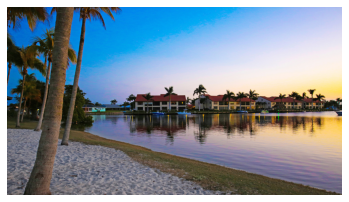

Question :آیا اینجا ساحل است؟
Top Predicted answers:  [('بله', 82.27603), ('نه', 17.691813), ('قایقها', 0.021025112), ('دریاچه', 0.0047681867), ('قایق', 0.0011239725)]


In [ ]:
# question = 'لباس کودک چه رنگی است؟'
# image_path = '/content/drive/My Drive/Demo_VQA/COCO_test2015_000000007594.jpg'

question = 'آیا اینجا ساحل است؟'
image_path = '/content/MW-HM224_Liv_fl_ZG_20190626101434.jpg'


im_features = load_and_proccess_image(image_path)
ques_features = preprocess_question(question)

x_im = [im_features]
x_ques = [ques_features]

x_im = np.array(x_im)
x_ques = np.array(x_ques)

y_pred = model.predict([x_ques, x_im])

class_indices = tf.math.top_k(y_pred,k=5).indices.numpy()
percentages = tf.math.top_k(y_pred,k=5).values.numpy()[0] * 100

with open('/content/drive/My Drive/Demo_VQA/label2vocab.json', 'r') as file:
    ans_vocab =  json.load(file)

predictions = []
for idx,i in enumerate(class_indices[0]):
    predictions.append((ans_vocab[str(i)],percentages[idx]))



img=mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()
print("Question :" + question)
print("Top Predicted answers: ",predictions)